In [ ]:
import random
import numpy as np
import cupy as cp
from numba import cuda

class Agent:
    def __init__(self):
        self.money = 0
        self.class_type = 'middle'

    def consume(self, seller, amount):
        self.money -= amount
        seller.money += amount

def roulette_wheel_selection_gpu(probs):
    cumulative_probs = cp.cumsum(probs)
    r = cp.random.random() * cumulative_probs[-1]
    index = cp.searchsorted(cumulative_probs, r)
    return index.item()

class Simulation:
    def __init__(self, num_agents, num_time_steps,business_percentage=0.2):
        self.num_agents = num_agents
        self.num_time_steps = num_time_steps
        self.agents = [Agent() for _ in range(num_agents)]
        self.total_tax = 0
        self.update_thresholds()
        self.update_wealth()
        self.segregate_agents()
        self.trade_probs = cp.zeros((self.num_agents, self.num_agents))
        self.initialize_trade_probabilities()
        self.rich_agent_wealth = []
        self.middle_agent_wealth = []
        self.poor_agent_wealth = []
        self.rich_agent_classes = []
        self.middle_agent_classes = []
        self.poor_agent_classes = []
        self.business_percentage = business_percentage
        self.business_success_prob = 0.6

    def update_wealth(self):
        wealth_values = [random.uniform(0.1, 3) for _ in range(int(0.5 * self.num_agents))] + \
                        [random.uniform(3, 12) for _ in range(int(0.4 * self.num_agents))] + \
                        [random.uniform(12, 50) for _ in range(int(0.1 * self.num_agents))]
        random.shuffle(wealth_values)
        for i, agent in enumerate(self.agents):
            agent.money = wealth_values[i]

    def calculate_tax(self, wealth):
        slabs = [3, 6, 9, 12, 15]
        rates = [0, 0.05, 0.1, 0.15, 0.2, 0.3]
        tax = 0
        for i, slab in enumerate(slabs):
            if wealth <= slab:
                return tax + rates[i] * (wealth - (slabs[i-1] if i > 0 else 0))
            tax += rates[i] * (slab - (slabs[i-1] if i > 0 else 0))
        return tax + rates[-1] * (wealth - slabs[-1])

    # def calculate_trade_prob(self, agent1, agent2):
    #     wealth_diff = cp.abs(agent1 - agent2)
    #     return cp.exp(-wealth_diff)
    def calculate_trade_prob(self, a, b):
      wealth_diff = cp.abs(a - b)
      return cp.exp(-wealth_diff)
    def initialize_trade_probabilities(self):
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                trade_prob = self.calculate_trade_prob(self.agents[i].money, self.agents[j].money)
                self.trade_probs[i, j] = trade_prob
                self.trade_probs[j, i] = trade_prob

    # def update_trade_probabilities(self, agent1_index, agent2_index):
    #     for i in range(self.num_agents):
    #         if i != agent1_index:
    #             self.trade_probs[agent1_index, i] = self.calculate_trade_prob(self.agents[agent1_index], self.agents[i])
    #             self.trade_probs[i, agent1_index] = self.trade_probs[agent1_index, i]
    #         if i != agent2_index:
    #             self.trade_probs[agent2_index, i] = self.calculate_trade_prob(self.agents[agent2_index], self.agents[i])
    #             self.trade_probs[i, agent2_index] = self.trade_probs[agent2_index, i]

    def update_trade_probabilities(self, agent1_index, agent2_index):
        agent1_money = self.agents[agent1_index].money
        agent2_money = self.agents[agent2_index].money
        other_agents_money = cp.array([agent.money for i, agent in enumerate(self.agents) if i not in (agent1_index, agent2_index)])

        # Calculate trade probabilities for agent1 and agent2
        trade_probs_agent1 = self.calculate_trade_prob(agent1_money, other_agents_money)
        trade_probs_agent2 = self.calculate_trade_prob(agent2_money, other_agents_money)

        # Initialize full-sized arrays for trade probabilities with zeros
        full_trade_probs_agent1 = cp.zeros(self.num_agents)
        full_trade_probs_agent2 = cp.zeros(self.num_agents)

        # Set the probabilities for the other agents (excluding agent1 and agent2)
        mask_other_agents = cp.array([i for i in range(self.num_agents) if i not in (agent1_index, agent2_index)])
        full_trade_probs_agent1[mask_other_agents] = trade_probs_agent1
        full_trade_probs_agent2[mask_other_agents] = trade_probs_agent2

        # Update the trade probabilities matrix
        self.trade_probs[agent1_index, :] = full_trade_probs_agent1
        self.trade_probs[:, agent1_index] = full_trade_probs_agent1
        self.trade_probs[agent2_index, :] = full_trade_probs_agent2
        self.trade_probs[:, agent2_index] = full_trade_probs_agent2


    def update_agents(self):
        agent1_index = np.random.randint(0, self.num_agents)
        agent1 = self.agents[agent1_index]
        agent_probs = self.trade_probs[agent1_index]
        agent2_index = roulette_wheel_selection_gpu(agent_probs)
        agent2 = self.agents[agent2_index]
        transaction_amount = 0.075 * (agent1.money * agent2.money) / (agent1.money + agent2.money)
        agent1.consume(agent2, transaction_amount)
        self.update_trade_probabilities(agent1_index, agent2_index)

    def deduct_tax(self):
        for agent in self.agents:
            tax = self.calculate_tax(agent.money)
            agent.money -= tax
            self.total_tax += tax

    def redist(self):
        add_val = self.total_tax / self.num_agents
        for agent in self.agents:
            agent.money += add_val
        self.total_tax = 0

    def update_thresholds(self):
        wealths = [agent.money for agent in self.agents]
        sorted_wealths = np.sort(wealths)
        self.lower_threshold = np.percentile(sorted_wealths, 50)
        self.upper_threshold = np.percentile(sorted_wealths, 90)

    def segregate_agents(self):
        for agent in self.agents:
            if agent.money <= self.lower_threshold:
                agent.class_type = 'poor'
            elif agent.money >= self.upper_threshold:
                agent.class_type = 'rich'
            else:
                agent.class_type = 'middle'

    def select_and_track_agents(self):
        random.shuffle(self.agents)
        for agent in self.agents:
            if agent.class_type == 'rich':
                self.rich_agent = agent
                break
        for agent in self.agents:
            if agent.class_type == 'middle':
                self.middle_agent = agent
                break
        for agent in self.agents:
            if agent.class_type == 'poor':
                self.poor_agent = agent
                break
        self.rich_agent_wealth.append(self.rich_agent.money)
        self.middle_agent_wealth.append(self.middle_agent.money)
        self.poor_agent_wealth.append(self.poor_agent.money)
        self.rich_agent_classes.append(self.rich_agent.class_type)
        self.middle_agent_classes.append(self.middle_agent.class_type)
        self.poor_agent_classes.append(self.poor_agent.class_type)

    def record_agent_classes(self):
        self.rich_agent_classes.append(self.rich_agent.class_type)
        self.middle_agent_classes.append(self.middle_agent.class_type)
        self.poor_agent_classes.append(self.poor_agent.class_type)

    def business_venture(self):
        # Select a subset of agents to venture into business
        num_business_agents = int(self.business_percentage * self.num_agents)
        business_agents = random.sample(self.agents, num_business_agents)

        for agent in business_agents:
            # Each agent invests a percentage of their wealth into the business
            investment = 0.3 * agent.money  # For example, 30% of their wealth

            if random.random() <= self.business_success_prob:
                # If the business succeeds, the agent earns a profit (e.g., 2x the investment)
                profit = 2 * investment
                agent.money += profit
            else:
                # If the business fails, the agent loses the investment
                agent.money -= investment

def gini_coefficient(wealths):
    n = len(wealths)
    if n == 0:
        return 0
    sorted_wealths = np.sort(wealths)
    diff_matrix = np.abs(sorted_wealths[:, None] - sorted_wealths)
    mean_abs_diff = np.mean(diff_matrix)
    mean_wealth = np.mean(sorted_wealths)
    gini_index = mean_abs_diff / (2 * mean_wealth)
    return gini_index


In [ ]:
num_agents = 1000
num_time_steps = 100000
gini_indices = []
sim = Simulation(num_agents, num_time_steps)

for i in range(100):
    sim.run_simulation()
    if i % 50 == 0:
        sim.update_thresholds()
    sim.segregate_agents()
    if i == 1:
        sim.select_and_track_agents()
    elif i > 1:
        sim.rich_agent_wealth.append(sim.rich_agent.money)
        sim.middle_agent_wealth.append(sim.middle_agent.money)
        sim.poor_agent_wealth.append(sim.poor_agent.money)
        sim.record_agent_classes()
    current_wealths = [agent.money for agent in sim.agents]
    gini_index = gini_coefficient(current_wealths)
    gini_indices.append(gini_index)
    print("Iteration ", i + 1, " complete")

Iteration  1  complete
Iteration  2  complete
Iteration  3  complete
Iteration  4  complete
Iteration  5  complete
Iteration  6  complete
Iteration  7  complete
Iteration  8  complete
Iteration  9  complete
Iteration  10  complete
Iteration  11  complete
Iteration  12  complete
Iteration  13  complete
Iteration  14  complete
Iteration  15  complete
Iteration  16  complete
Iteration  17  complete
Iteration  18  complete
Iteration  19  complete
Iteration  20  complete
Iteration  21  complete
Iteration  22  complete
Iteration  23  complete
Iteration  24  complete
Iteration  25  complete
Iteration  26  complete
Iteration  27  complete
Iteration  28  complete
Iteration  29  complete
Iteration  30  complete
Iteration  31  complete
Iteration  32  complete
Iteration  33  complete
Iteration  34  complete
Iteration  35  complete
Iteration  36  complete
Iteration  37  complete
Iteration  38  complete
Iteration  39  complete
Iteration  40  complete
Iteration  41  complete
Iteration  42  complete
I

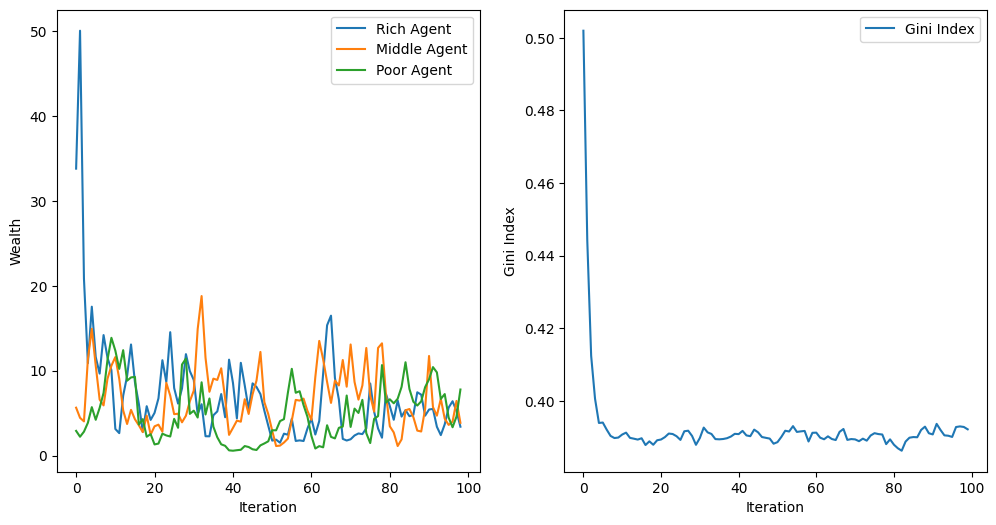

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sim.rich_agent_wealth, label='Rich Agent')
plt.plot(sim.middle_agent_wealth, label='Middle Agent')
plt.plot(sim.poor_agent_wealth, label='Poor Agent')
plt.xlabel('Iteration')
plt.ylabel('Wealth')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(gini_indices, label='Gini Index')
plt.xlabel('Iteration')
plt.ylabel('Gini Index')
plt.legend()
